In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import os

In [2]:
cwd=os.getcwd()

![](images/photo_top.jpg)

# Snow loss prediction for PV farms

**Snowfall can affect the performance of the PV panels adversely**. Snowpack’s on the surface of the panels prevent solar irradiations from reaching the PV cells. Therefore, an energy yield reduction is the result of partial or full shading of the panels by snow. This snowfall-related power reduction which is referred to as snow loss affects the overall net profit of PV farms in snow-prone areas. Hence, modeling and predicting the snow loss of PV farms in cold regions is of significant importance and can provide a clearer perspective of the performance and efficiency of these systems in the future.

## A problem

The challenge is to create a model capable of predicting the percentage of lost power due to snow.

## Hypothesis

Is it possible to use predictive weather data with local snow measurements to create a regression model to predict snow losses?

## Data Preparation

### Contents 
1. Weather data
2. Shading data
3. Descriptive Analysis

### 1. Weather data 
### Reading csv file with weather data into DataFrame

In [3]:
files = [file for file in os.listdir(cwd+'\\data\\forecasts_jan-feb_2021\\')]
files1 =[]
data = pd.DataFrame()
data1 = pd.DataFrame()
for file in files:
    date_of_reading = pd.to_datetime(file.split('_')[-1].split('.')[0], format='%Y%m%d%H%M')
    if (date_of_reading > pd.to_datetime('2021-01-13')) & (date_of_reading < pd.to_datetime('2021-02-25')) & (file.split('_')[-1].split('.')[0][-4:] == '0631'):

        if file.split('_')[3] in ['Vasylivka', 'Novokondakove']:
            df1 = pd.read_csv(cwd+'\\data\\forecasts_jan-feb_2021\\'+file, sep=';', error_bad_lines=False, skiprows=56)
            df1['ФЕС'] = file.split('_')[3]
            df1 = df1[pd.to_datetime(df1['Date']) == pd.to_datetime(file.split('_')[-3], format='%Y%m%d')]
            data1 = pd.concat([data1, df1])

        elif file.split('_')[3] in ['Inhulets', 'Oleshky', 'Yelanets']:
            df = pd.read_csv(cwd+'\\data\\forecasts_jan-feb_2021\\'+file, sep=';', error_bad_lines=False, skiprows=50)
            df['ФЕС'] = file.split('_')[3] + '_' + file.split('_')[4]
            df = df[pd.to_datetime(df['Date']) == pd.to_datetime(file.split('_')[-3], format='%Y%m%d')]
            data = pd.concat([data, df])

        else:
            df = pd.read_csv(cwd+'\\data\\forecasts_jan-feb_2021\\'+file, sep=';', error_bad_lines=False, skiprows=50)
            df['ФЕС'] = file.split('_')[3]
            df = df[pd.to_datetime(df['Date']) == pd.to_datetime(file.split('_')[-3], format='%Y%m%d')]           
            data = pd.concat([data, df])

### Replacing names with codenames

In [4]:
names_1 = pd.read_excel(cwd+'\\data\\Замена станций_прогнозы.xlsx')
data = data.merge(names_1, how='left', on='ФЕС')
data['ФЕС'] = data['new_name']
data = data.drop(columns='new_name')

In [5]:
data.head()

,Date,Time,GHI,GTI,DIF,DNI,TEMP,WS,WD,PVOUT,ФЕС
0,13.01.2021,00:30,0,0,0,0,-3.1,6.4,33,0.0,D15
1,13.01.2021,01:30,0,0,0,0,-3.4,6.7,27,0.0,D15
2,13.01.2021,02:30,0,0,0,0,-3.5,7.1,41,0.0,D15
3,13.01.2021,03:30,0,0,0,0,-3.5,7.3,48,0.0,D15
4,13.01.2021,04:30,0,0,0,0,-3.6,6.8,42,0.0,D15


We are interested in **TEMP, WS, WD** columns.
* TEMP - temperature;
* WS - wind speed;
* WD - wind direction;

### Finding mean value for each day and station

In [6]:
time = ['08:30', '09:30', '10:30', '11:30', '12:30', '13:30', '14:30', '15:30', '16:30', '17:30', '18:30']
data = data[data['Time'].isin(time)]
data1 = data.groupby(['Date', 'ФЕС']).mean().reset_index()

### 2. Shading data
This csv file is a result of another project

In [7]:
data_ml = pd.read_csv(cwd+'\\data\\shading_data.csv')

In [8]:
data_ml['Дата'] = pd.to_datetime(data_ml['Дата'])
data1['Date'] = pd.to_datetime(data1['Date'])
data_ml3 = data_ml.merge(data1, how='inner', left_on=['Дата', 'ФЕС'], right_on=['Date', 'ФЕС']).dropna()

In [17]:
data_ml3

,Unnamed: 0,Дата,ФЕС,Коригування_x,shading,shading_res,Коригування_y,Необхідне коригування,Вартість до коригування--Негативні,Вартість до коригування--Позитивні,...,check,Date,GHI,GTI,DIF,DNI,TEMP,WS,WD,PVOUT
0,0,2021-01-14,A1,0.299834,100,0,0.299834,0.524771,876.0,1.0,...,8.496370e-12,2021-01-14,126.909091,223.454545,53.000000,240.272727,-1.000000,2.336364,225.636364,4072.531545
1,1,2021-01-14,B2,0.399898,80,60,0.399898,0.002149,355.0,0.0,...,-2.644773e-12,2021-01-14,80.818182,106.272727,63.454545,56.818182,-1.900000,3.000000,220.727273,1804.674909
2,2,2021-01-14,B5,0.185515,100,20,0.185515,0.635437,394.0,2.0,...,3.997203e-11,2021-01-14,118.272727,196.909091,59.454545,202.000000,-1.963636,2.600000,222.272727,1679.389909
3,3,2021-01-14,B6,0.299959,100,100,0.299959,0.179626,280.0,0.0,...,-1.334433e-11,2021-01-14,57.363636,66.818182,51.636364,20.363636,-2.418182,3.490909,248.090909,382.382455
4,5,2021-01-14,D15,0.100000,100,0,0.100000,1.334373,165.0,28.0,...,1.387779e-17,2021-01-14,93.000000,142.545455,64.090909,112.000000,-2.218182,3.363636,216.272727,1996.688364
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,272,2021-02-20,C44,0.874864,20,0,0.874864,1.362095,2.0,8.0,...,4.437151e-11,2021-02-20,226.454545,338.272727,74.090909,332.181818,-1.954545,2.672727,182.272727,5841.944182
77,273,2021-02-20,B2,0.500000,60,40,0.500000,0.452574,381.0,0.0,...,0.000000e+00,2021-02-20,201.363636,273.090909,99.272727,226.090909,-5.054545,2.854545,224.000000,5382.918818
78,276,2021-02-20,R35,0.400000,100,0,0.400000,0.861004,76.0,85.0,...,5.551115e-17,2021-02-20,225.000000,332.272727,80.272727,308.181818,-3.536364,1.481818,193.000000,6023.412182
79,277,2021-02-20,S36,0.500000,0,40,0.500000,1.573378,0.0,160.0,...,0.000000e+00,2021-02-20,209.272727,299.636364,86.454545,269.181818,-4.054545,2.709091,233.818182,3553.540182


### 3. Descriptive Analysis

In [23]:
data_ml3['Необхідне коригування'].corr(data_ml3['shading_res'])

-0.6395217450619345

(array([ 6.,  9.,  6.,  9.,  3., 11., 14., 13.,  3.,  7.]),
 array([-15.05454545, -13.16909091, -11.28363636,  -9.39818182,
         -7.51272727,  -5.62727273,  -3.74181818,  -1.85636364,
          0.02909091,   1.91454545,   3.8       ]),
 <BarContainer object of 10 artists>)

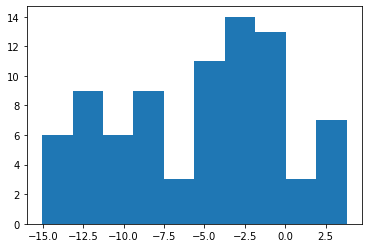

In [18]:
plt.hist(data_ml3['TEMP'])

## Snow loss prediction model

In [9]:
X = data_ml3[['TEMP', 'shading', 'shading_res', 'WS', 'WD']]
y = data_ml3[['Необхідне коригування']]

In [10]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=26, test_size=0.3)

In [11]:
training_accuracy = []
test_accuracy = []
neighbors_settings = range(1,50)

for n_neighbors in neighbors_settings:
    regr = KNeighborsRegressor(n_neighbors=n_neighbors)
    regr.fit(X_train, y_train)
    training_accuracy.append(regr.score(X_train, y_train))
    test_accuracy.append(regr.score(X_test, y_test))

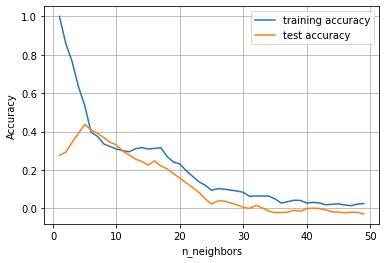

In [12]:
plt.plot(neighbors_settings, training_accuracy, label="training accuracy")
plt.plot(neighbors_settings, test_accuracy, label="test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("n_neighbors")
plt.grid()
plt.legend()

In [13]:
max(test_accuracy)

0.43768833153846964

In [14]:
neighbors_settings[test_accuracy.index(max(test_accuracy))]

5

In [16]:
df_test = data_ml3.copy()
df_test['Дата'] = pd.to_datetime(df_test['Дата'])
#df_test = data1.merge(df_test, how='inner', right_on=['Дата', 'ФЕС'], left_on=['Date', 'ФЕС']).dropna()
#df_test = df_test.merge(x_data, how='inner', right_on=['Дата', 'ФЕС'], left_on=['Date', 'ФЕС']).dropna()

df_test['Коригування'] = regr.predict(df_test[['TEMP', 'shading', 'shading_res', 'WS', 'WD']])
df_test['Прогноз (скоригований), МВт*год'] = df_test['Прогноз (до коригування), МВт*год'] * df_test['Коригування']
df_test = df_test.rename({'Date': 'Дата'}, axis=1)
df_test['Відхилення (після коригування), МВт*год'] = df_test['Факт, МВт*год'] - df_test['Прогноз (скоригований), МВт*год']
df1_test = df_test.groupby(['Дата','ФЕС']).mean()[['Коригування', 'Необхідне коригування']]
df1_test['Вартість до коригування--Негативні'] = df_test[df_test['Відхилення (до коригування), МВт*год']<0].groupby(['Дата','ФЕС']).apply(lambda x: sum(x['Відхилення (до коригування), МВт*год']*(x['Ціна dam, EUR/кВт*год'] - x['Ціна негативного небалансу, EUR/кВт*год']))*1000).round()
df1_test.fillna(0, inplace=True)
df1_test['Вартість до коригування--Позитивні'] = df_test[df_test['Відхилення (до коригування), МВт*год']>0].groupby(['Дата','ФЕС']).apply(lambda x: sum(x['Відхилення (до коригування), МВт*год']*(x['Ціна dam, EUR/кВт*год'] - x['Ціна позитивного небалансу, EUR/кВт*год']))*1000).round()
df1_test.fillna(0, inplace=True)
df1_test['Вартість до коригування--Сумарні'] = df1_test['Вартість до коригування--Негативні']+df1_test['Вартість до коригування--Позитивні']

df1_test['Вартість після коригування--Негативні'] = df_test[df_test['Відхилення (після коригування), МВт*год']<0].groupby(['Дата','ФЕС']).apply(lambda x: sum(x['Відхилення (після коригування), МВт*год']*(x['Ціна dam, EUR/кВт*год'] - x['Ціна негативного небалансу, EUR/кВт*год']))*1000).round()
df1_test.fillna(0, inplace=True)
df1_test['Вартість після коригування--Позитивні'] = df_test[df_test['Відхилення (після коригування), МВт*год']>0].groupby(['Дата','ФЕС']).apply(lambda x: sum(x['Відхилення (після коригування), МВт*год']*(x['Ціна dam, EUR/кВт*год'] - x['Ціна позитивного небалансу, EUR/кВт*год']))*1000).round()
df1_test.fillna(0, inplace=True)
df1_test['Вартість після коригування--Сумарні'] = df1_test['Вартість після коригування--Негативні']+df1_test['Вартість після коригування--Позитивні']

df1_test['Результат коригування, EUR'] = df1_test['Вартість до коригування--Сумарні']-df1_test['Вартість після коригування--Сумарні']
df1_test = df1_test.reset_index()

KeyError: 'Прогноз (до коригування), МВт*год'